In [ ]:
# =============================================================================
# PROJECT NAME: Activity Recognition on Sensor Data (Project Option 4)
# TOPIC: Comparative Analysis of Feature Selection Methods
# ZEHRA OZTURK
# =============================================================================

# -----------------------------------------------------------------------------
# SECTION 1: LIBRARIES AND CONFIGURATION
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Modules
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
warnings.filterwarnings('ignore') # Warnings suppressed for a cleaner report

print("Necessary libraries loaded and configuration complete.")

Necessary libraries loaded and configuration complete.


In [ ]:
# -----------------------------------------------------------------------------
# SECTION 2: DATA DESCRIPTION & PREPROCESSING
# -----------------------------------------------------------------------------
# Source: UCI Machine Learning Repository - Human Activity Recognition Using Smartphones

# Loading Data
# Note: Adjust path for Colab or local directory.
train_df = pd.read_csv(r"/content/train.csv")
test_df = pd.read_csv(r"/content/test.csv")

print(f"Training Set Dimensions: {train_df.shape}")
print(f"Test Set Dimensions:     {test_df.shape}")

# Data Quality Check
# Checking for Missing Values and Duplicates
if train_df.isnull().sum().sum() == 0:
    print("Data Quality: No missing values found.")
else:
    print(f"Warning: {train_df.isnull().sum().sum()} missing values detected.")

if train_df.duplicated().sum() == 0:
    print("Data Quality: No duplicate observations found.")

# Separating Target Variable and Features
# The 'subject' column represents the person ID and is excluded from the model.
x_train = train_df.drop(['Activity', 'subject'], axis=1)
y_train = train_df['Activity']

x_test = test_df.drop(['Activity', 'subject'], axis=1)
y_test = test_df['Activity']

# Target Variable Encoding (Label Encoding)
# Categorical activity names (Walking, Sitting, etc.) are converted to numerical format.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nClasses: {le.classes_}")

Training Set Dimensions: (7352, 563)
Test Set Dimensions:     (2947, 563)
Data Quality: No missing values found.
Data Quality: No duplicate observations found.

Classes: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [ ]:
# -----------------------------------------------------------------------------
# HELPER FUNCTION: MODEL EVALUATION
# -----------------------------------------------------------------------------
# Calculates Accuracy, F1, AUC, and 5-Fold Cross-Validation (CV).
def evaluate_model(model, x_train, y_train, x_test, y_test, method_name, feature_count):
    start = time.time()
    model.fit(x_train, y_train)
    end = time.time()
    training_time = end - start

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test) # Required for AUC

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # AUC Calculation (Multi-class 'ovr' - One vs Rest strategy)
    try:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        auc = 0 # In case of potential errors (binary/multi mismatch)

    # Cross Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
    cv_mean = cv_scores.mean()

    print(f"\n--- {method_name} RESULTS ---")
    print(f"Feature Count:       {feature_count}")
    print(f"Training Time:       {training_time:.4f} sec")
    print(f"CV Accuracy (Avg):   %{cv_mean*100:.2f}")
    print(f"Test Accuracy:       %{acc*100:.2f}")
    print(f"Test F1 Score:       %{f1*100:.2f}")
    print(f"Test AUC Score:      %{auc*100:.2f}")

    return {
        'Method': method_name,
        'Feature Count': feature_count,
        'Accuracy': acc * 100,
        'F1 Score': f1 * 100,
        'AUC Score': auc * 100,
        'CV Accuracy': cv_mean * 100,
        'Training Time (sec)': training_time
    }

# List to hold results
results_list = []

In [ ]:
# -----------------------------------------------------------------------------
# SECTION 3: BASELINE MODEL (BENCHMARK)
# -----------------------------------------------------------------------------
# A reference performance is established using all features (561 total).
print("1. Baseline Model (All Features) Running...")

rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
res_base = evaluate_model(rf_base, x_train, y_train_encoded, x_test, y_test_encoded,
                          "Baseline (All)", x_train.shape[1])
results_list.append(res_base)

1. Baseline Model (All Features) Running...

--- Baseline (All) RESULTS ---
Feature Count:       561
Training Time:       21.5264 sec
CV Accuracy (Avg):   %98.16
Test Accuracy:       %92.67
Test F1 Score:       %92.66
Test AUC Score:      %99.53


In [ ]:
# -----------------------------------------------------------------------------
# SECTION 4: FEATURE SELECTION METHODS
# -----------------------------------------------------------------------------

# Target Feature Count: 100
# This number was selected experimentally to retain high variance and distinctive features.
k_target = 100

# --- METHOD 4.1: FILTER METHOD (ANOVA) ---
# Selects based on statistical dependency (ANOVA F-value). Independent of the model.
print("\n2. Filter Method (SelectKBest - ANOVA) Running...")

# Important: Fit is ONLY applied to the training set (Preventing Data Leakage)
selector_filter = SelectKBest(score_func=f_classif, k=k_target)
x_train_filter = selector_filter.fit_transform(x_train, y_train_encoded)
x_test_filter = selector_filter.transform(x_test)

rf_filter = RandomForestClassifier(n_estimators=100, random_state=42)
res_filter = evaluate_model(rf_filter, x_train_filter, y_train_encoded, x_test_filter, y_test_encoded,
                            "Filter (ANOVA)", k_target)
results_list.append(res_filter)


# --- METHOD 4.2: EMBEDDED METHOD (Tree Importance) ---
# Uses the 'feature_importances_' metric inherent to the Random Forest algorithm.
print("\n3. Embedded Method (Random Forest Importance) Running...")

# Step 1: Train a temporary model to find importance scores
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42)
rf_selector.fit(x_train, y_train_encoded)

# Step 2: Select based on a specific threshold
# '1.25*mean' threshold selects features 25% more important than the average.
selector_embedded = SelectFromModel(rf_selector, threshold='1.25*mean', prefit=True)
x_train_emb = selector_embedded.transform(x_train)
x_test_emb = selector_embedded.transform(x_test)

num_emb_features = x_train_emb.shape[1]

rf_embedded = RandomForestClassifier(n_estimators=100, random_state=42)
res_embedded = evaluate_model(rf_embedded, x_train_emb, y_train_encoded, x_test_emb, y_test_encoded,
                              "Embedded (RF Imp.)", num_emb_features)
results_list.append(res_embedded)


# --- METHOD 4.3: WRAPPER METHOD (RFE) ---
# Recursive Feature Elimination: Iteratively eliminates the weakest features.
# This is the most computationally expensive method.
print("\n4. Wrapper Method (RFE) Running (This may take time)...")

# We use a faster "estimator" (DecisionTree) for RFE.
# Using RF here would make the processing time excessively long (Computational Efficiency).
rfe_estimator = DecisionTreeClassifier(random_state=42)
selector_rfe = RFE(estimator=rfe_estimator, n_features_to_select=k_target, step=50)

# Measuring Selection Time
start_select = time.time()
x_train_rfe = selector_rfe.fit_transform(x_train, y_train_encoded)
x_test_rfe = selector_rfe.transform(x_test)
select_time = time.time() - start_select
print(f"RFE Selection Time: {select_time:.2f} seconds")

rf_wrapper = RandomForestClassifier(n_estimators=100, random_state=42)
res_wrapper = evaluate_model(rf_wrapper, x_train_rfe, y_train_encoded, x_test_rfe, y_test_encoded,
                             "Wrapper (RFE)", k_target)

# Updating cost by adding selection time to total training time
res_wrapper['Training Time (sec)'] += select_time
results_list.append(res_wrapper)


2. Filter Method (SelectKBest - ANOVA) Running...

--- Filter (ANOVA) RESULTS ---
Feature Count:       100
Training Time:       8.5268 sec
CV Accuracy (Avg):   %94.68
Test Accuracy:       %88.77
Test F1 Score:       %88.74
Test AUC Score:      %99.09

3. Embedded Method (Random Forest Importance) Running...

--- Embedded (RF Imp.) RESULTS ---
Feature Count:       97
Training Time:       7.8532 sec
CV Accuracy (Avg):   %98.01
Test Accuracy:       %90.50
Test F1 Score:       %90.48
Test AUC Score:      %99.18

4. Wrapper Method (RFE) Running (This may take time)...
RFE Selection Time: 50.75 seconds

--- Wrapper (RFE) RESULTS ---
Feature Count:       100
Training Time:       9.0951 sec
CV Accuracy (Avg):   %98.37
Test Accuracy:       %91.92
Test F1 Score:       %91.92
Test AUC Score:      %99.46



FINAL COMPARISON TABLE


,Method,Feature Count,Accuracy,F1 Score,AUC Score,CV Accuracy,Training Time (sec)
0,Baseline (All),561,92.670512,92.663095,99.532033,98.163746,21.526377
1,Filter (ANOVA),100,88.768239,88.736209,99.088442,94.681706,8.526847
2,Embedded (RF Imp.),97,90.498812,90.480408,99.179678,98.014114,7.853200
3,Wrapper (RFE),100,91.923990,91.921740,99.462368,98.367800,59.847146


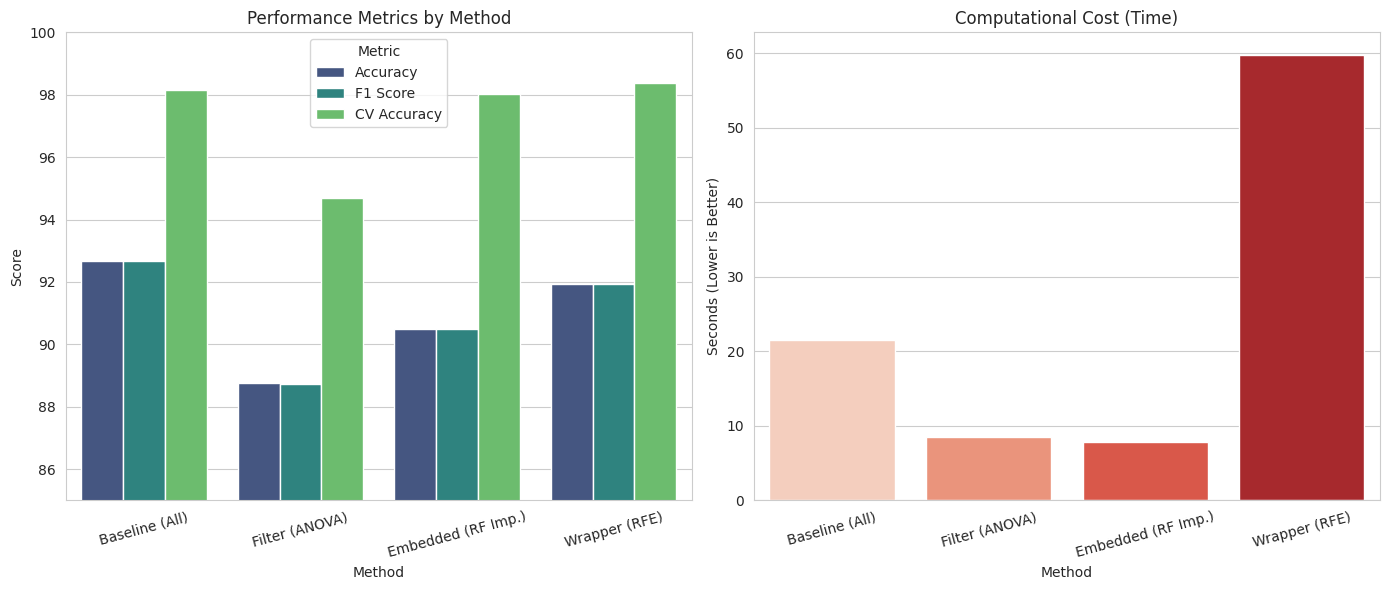

In [ ]:
# -----------------------------------------------------------------------------
# SECTION 5: COMPARATIVE PERFORMANCE EVALUATION
# -----------------------------------------------------------------------------
df_results = pd.DataFrame(results_list)

print("\n" + "="*50)
print("FINAL COMPARISON TABLE")
print("="*50)
display(df_results)

# Visualization 1: Accuracy and F1 Score
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df_melted = df_results.melt(id_vars="Method", value_vars=["Accuracy", "F1 Score", "CV Accuracy"], var_name="Metric", value_name="Score")
sns.barplot(x="Method", y="Score", hue="Metric", data=df_melted, palette="viridis")
plt.ylim(85, 100)
plt.title("Performance Metrics by Method")
plt.xticks(rotation=15)

# Visualization 2: Computational Cost (Time)
plt.subplot(1, 2, 2)
sns.barplot(x="Method", y="Training Time (sec)", data=df_results, palette="Reds")
plt.title("Computational Cost (Time)")
plt.ylabel("Seconds (Lower is Better)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [7]:
# -----------------------------------------------------------------------------
# SECTION 6: INTERPRETABILITY AND DOMAIN KNOWLEDGE
# -----------------------------------------------------------------------------
# Evaluation of significance within the problem context.

print("\n--- INTERPRETABILITY ANALYSIS (Embedded Method) ---")
# Getting names of features selected by the embedded method
mask = selector_embedded.get_support()
selected_feat_names = x_train.columns[mask]

# Distribution by sensor type
acc_features = [f for f in selected_feat_names if 'Acc' in f]
gyro_features = [f for f in selected_feat_names if 'Gyro' in f]

print(f"Model selected a total of {len(selected_feat_names)} features.")
print(f"{len(acc_features)} of these are 'Accelerometer' (Acc) data.")
print(f"{len(gyro_features)} of these are 'Gyroscope' (Gyro) data.")

print("\nComment:")
if len(acc_features) > len(gyro_features):
    print("Results indicate that linear acceleration (Acc) is more deterministic than\n"
          "angular change (Gyro) in distinguishing human activity (Walking, Sitting, etc.).\n"
          "This is consistent with findings in the literature (Anguita et al., 2013).")
else:
    print("Results indicate that gyroscope data plays a critical role in classification.")

print("\n--- PROJECT COMPLETED ---")


--- INTERPRETABILITY ANALYSIS (Embedded Method) ---
Model selected a total of 97 features.
77 of these are 'Accelerometer' (Acc) data.
17 of these are 'Gyroscope' (Gyro) data.

Comment:
Results indicate that linear acceleration (Acc) is more deterministic than
angular change (Gyro) in distinguishing human activity (Walking, Sitting, etc.).
This is consistent with findings in the literature (Anguita et al., 2013).

--- PROJECT COMPLETED ---
